# Exploring Model Explanations

In this notebook we demonstrate how to interpret Bert models using Captum library. In this particular case study we focus on a fine-tuned Hate Speech Detection model on hate_speech18 dataset using transformers library from Hugging Face: https://huggingface.co/transformers/

We show how to use interpretation hooks to examine and better understand embeddings, sub-embeddings, bert, and attention layers.

Note: Before running this tutorial, please install captum, seaborn, pandas, and matplotlib, transformers and datasets(from hugging face, tested on transformer version 4.3.0.dev0) python packages.

In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import BertTokenizer
from datasets import load_dataset

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerGradientXActivation

from lm import LanguageModel

The first step is to fine-tune BERT model on SQUAD dataset. This can be easiy accomplished by following the steps described in hugging face's official web site: https://github.com/huggingface/transformers#run_squadpy-fine-tuning-on-squad-for-question-answering

Note that the fine-tuning is done on a bert-base-uncased pre-trained model.

After we pretrain the model, we can load the tokenizer and pre-trained BERT model using the commands described below.

In [107]:
# makes sure we are using gpu if there is one available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");

# fine-tuned model checkpoint path
ckpt_path = 'Models/stf BSST-138/checkpoints/epoch=2-step=1481.ckpt'
# load model
model = LanguageModel.load_from_checkpoint(checkpoint_path=ckpt_path, num_classes=2)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

A helper function to perform forward pass of the model and make predictions.

In [108]:
def forward_func(inputs, attention_mask=None):
    logits, attn = model(inputs, attention_mask=attention_mask)
    return logits

In [109]:
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

def construct_input_ref_pair(text, sep_token_id, cls_token_id):
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]

    return torch.tensor([input_ids], device=device)
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)
    
def construct_whole_bert_embeddings(input_ids):
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)
    return input_embeddings

In [110]:
# build sample dataset
data = load_dataset('hate_speech18')
# let's take an instance from the dataset
subset = data['train'][0]
text = subset['text']
ground_truth = subset['label']

Using custom data configuration default
Reusing dataset hate_speech18 (C:\Users\jzcha\.cache\huggingface\datasets\hate_speech18\default\0.0.0\8033f254483a20d1d10b0f1b56ded1f54326b1617872c537f354a721a6951d47)


In [111]:
input_ids = construct_input_ref_pair(text, sep_token_id, cls_token_id)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

Sanity Check: makeing sure our model will predict the correct label


In [112]:
output_fwd = forward_func(input_ids, attention_mask=attention_mask)

print('Question: ', text)
print('Predicted Label: ', torch.argmax(output_fwd).item())
print('Expected Label: ', ground_truth)

Question:  As of March 13th , 2014 , the booklet had been downloaded over 18,300 times and counting .
Predicted Label:  0
Expected Label:  0


In [113]:
lig = LayerGradientXActivation(forward_func, model.classifier.bert.embeddings)

attributions = lig.attribute(
    inputs=input_ids, 
    target = torch.tensor(ground_truth).cuda().long(), 
    additional_forward_args=(attention_mask))


In [114]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

attributions_sum = summarize_attributions(attributions)

In [115]:
# Visualizing different word importances per attribution algorithm
vis = viz.VisualizationDataRecord(
                        attributions_sum,
                        torch.max(torch.softmax(output_fwd[0], dim=0)),
                        torch.argmax(output_fwd),
                        torch.argmax(output_fwd),
                        str(ground_truth),
                        attributions_sum.sum(),       
                        all_tokens,
                        convergence_score=None)

print('\033[1m', 'GradientXActivation Visualizations', '\033[0m')
viz.visualize_text([vis]);

 GradientXActivation Visualizations 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.99),0,0.68,"[CLS] as of march 13th , 2014 , the booklet had been downloaded over 18 , 300 times and counting . [SEP]"


In [116]:
lig = LayerGradientXActivation(forward_func, \
                                [model.classifier.bert.embeddings.word_embeddings, \
                                 model.classifier.bert.embeddings.token_type_embeddings,])

attributions = lig.attribute(inputs=(input_ids),
                                    target = torch.tensor(ground_truth).cuda().long(), 
                                  additional_forward_args=(attention_mask))

attributions_word = summarize_attributions(attributions[0])
attributions_token_type = summarize_attributions(attributions[1])

# Aux Function to compute topk attribution tokens, values, and indices 
def get_topk_attributed_tokens(attrs, k=5):
    values, indices = torch.topk(attrs, k)
    top_tokens = [all_tokens[idx] for idx in indices]
    return top_tokens, values, indices

# Generate topk for each input
top_words, top_words_val, top_word_ind = get_topk_attributed_tokens(attributions_word)
top_token_type, top_token_type_val, top_token_type_ind = get_topk_attributed_tokens(attributions_token_type)

# Stores and formats topk attributions in a Pandas dataframe for easier visualization
df_top = pd.DataFrame({'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words, top_word_ind, top_words_val)],
                   'Token Type(Index), Attribution': ["{} ({}), {}".format(ttype, pos, round(val.item(),2)) for ttype, pos, val in zip(top_token_type, top_token_type_ind, top_words_val)],
                   })
df_top.style.apply(['cell_ids: False'])

['{}({})'.format(token, str(i)) for i, token in enumerate(all_tokens)];

In [117]:
df_top

,"Word(Index), Attribution","Token Type(Index), Attribution"
0,"booklet (9), 0.65","[SEP] (21), 0.65"
1,"counting (19), 0.34","the (8), 0.34"
2,", (15), 0.21","300 (16), 0.21"
3,"had (10), 0.2","had (10), 0.2"
4,"2014 (6), 0.17","18 (14), 0.17"


In [118]:
layer_attrs = []

# The token that we would like to examine separately.
token_to_explain = 9 # the index of the token that we would like to examine more thoroughly
layer_attrs_dist = []


for i in range(model.classifier.config.num_hidden_layers):
    lc = LayerGradientXActivation(forward_func, model.classifier.bert.encoder.layer[i])
    layer_attributions = lc.attribute(inputs=input_ids, target=torch.tensor(ground_truth).cuda().long(), additional_forward_args=(attention_mask))
    layer_attributions = layer_attributions[0]
    layer_attrs.append(summarize_attributions(layer_attributions).cpu().detach().tolist())

    # storing attributions of the token id that we would like to examine in more detail in token_to_explain
    layer_attrs_dist.append(layer_attributions[0,token_to_explain,:].cpu().detach().tolist())

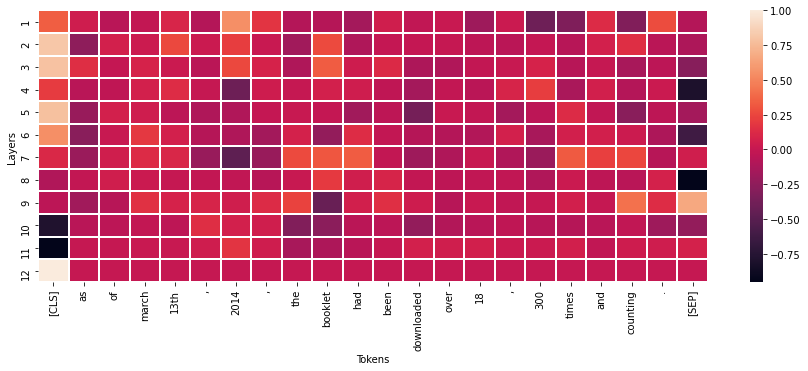

In [119]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

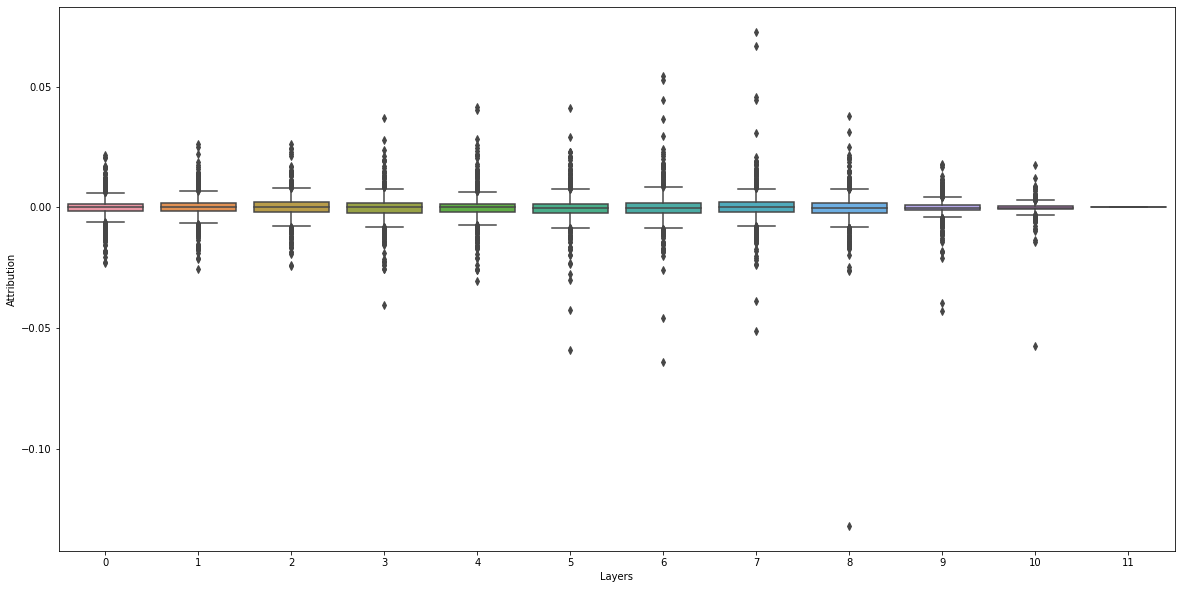

In [120]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

In [121]:
def pdf_attr(attrs, bins=100):
    return np.histogram(attrs, bins=bins, density=True)[0]

In [122]:
layer_attrs_pdf = map(lambda layer_attrs_dist: pdf_attr(layer_attrs_dist), layer_attrs_dist)
layer_attrs_pdf = np.array(list(layer_attrs_pdf))

# summing attribution along embedding diemension for each layer
# size: #layers
attr_sum = np.array(layer_attrs_dist).sum(-1)

# size: #layers
layer_attrs_pdf_norm = np.linalg.norm(layer_attrs_pdf, axis=-1, ord=1)

#size: #bins x #layers
layer_attrs_pdf = np.transpose(layer_attrs_pdf)

#size: #bins x #layers
layer_attrs_pdf = np.divide(layer_attrs_pdf, layer_attrs_pdf_norm, where=layer_attrs_pdf_norm!=0)


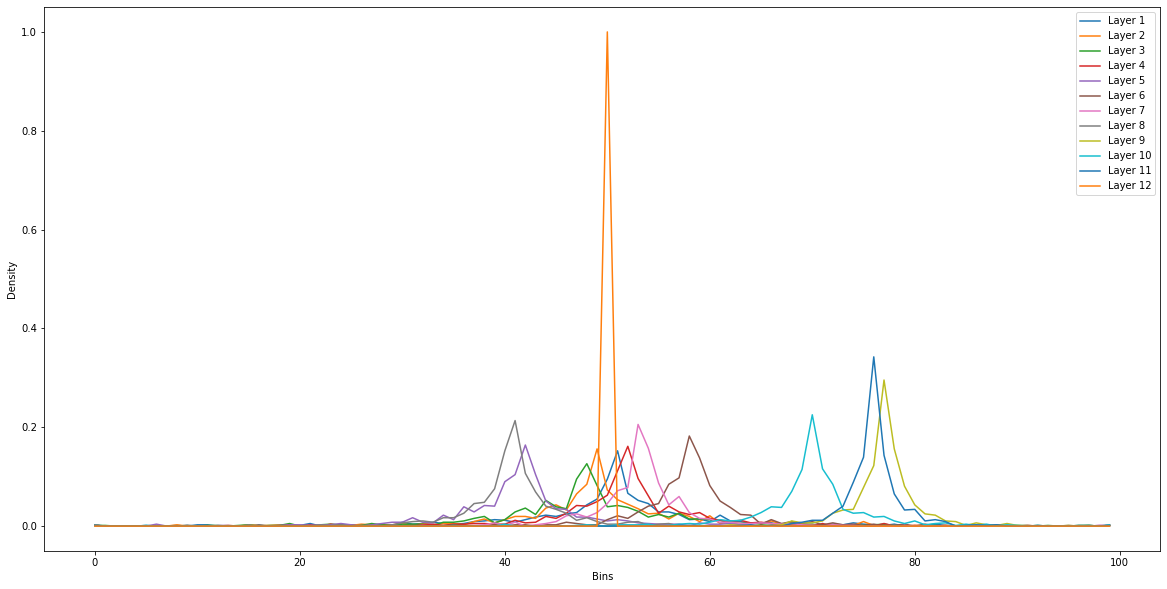

In [123]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(layer_attrs_pdf)
plt.xlabel('Bins')
plt.ylabel('Density')
plt.legend(['Layer '+ str(i) for i in range(1,13)])
plt.show()

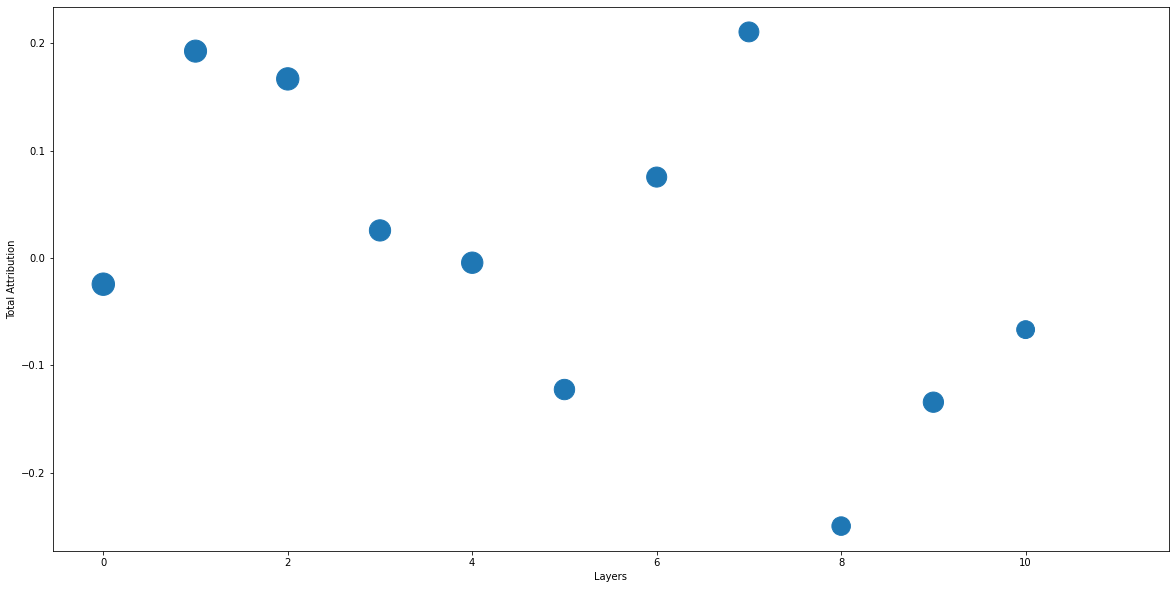

In [124]:
fig, ax = plt.subplots(figsize=(20,10))

# replacing 0s with 1s. np.log(1) = 0 and np.log(0) = -inf
layer_attrs_pdf[layer_attrs_pdf == 0] = 1
layer_attrs_pdf_log = np.log2(layer_attrs_pdf)

# size: #layers
entropies= -(layer_attrs_pdf * layer_attrs_pdf_log).sum(0)

plt.scatter(np.arange(12), attr_sum, s=entropies * 100)
plt.xlabel('Layers')
plt.ylabel('Total Attribution')
plt.show()